# Import Library

In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import os
import random
import shutil
import xml.etree.ElementTree as ET
import torch
import json

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import Image, clear_output

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset

## Download Dataset

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
token = {"username":"ssusie2737","key":"e9b8d049190b8efa5f5ba6b02d2a9a66"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v /content

- path is now set to: /content


In [ ]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

 98% 733M/750M [00:05<00:00, 150MB/s]
100% 750M/750M [00:05<00:00, 144MB/s]


In [ ]:
!unzip /content/datasets/jessicali9530/stanford-dogs-dataset/stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

## Reorg Directory Structure

In [ ]:
!rm -rf dataset

In [ ]:
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/train')
os.mkdir('/content/dataset/val')
os.mkdir('/content/dataset/test')

In [ ]:
def relocate_images(src_dir, dst_dir, num):
  for dir in os.listdir(src_dir):
    sub_src_dir = os.path.join(src_dir, dir)
    sub_dst_dir = os.path.join(dst_dir, dir)
    os.mkdir(sub_dst_dir)
    cnt = 0
    for file in os.listdir(sub_src_dir):
      shutil.copy(sub_src_dir + '/' + file, sub_dst_dir)
      os.remove(sub_src_dir + '/' + file)
      cnt += 1
      if(cnt == num):
        break

In [ ]:
# Set up train/val/test folders
relocate_images('/content/images/Images', '/content/dataset/train', 50) # 6000
relocate_images('/content/images/Images', '/content/dataset/val', 15) # 1800
relocate_images('/content/images/Images', '/content/dataset/test', 15) # 1800

# Algorithm

## Train

In [ ]:
# Base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(120, activation='softmax')(x)  

# Create  model
model = Model(inputs=base_model.input, outputs=predictions)

# Disable base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',  # Dir of training images
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/val',  # Dir of validation images
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 16,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // 16
)

17225924/17225924 [==============================] - 0s 0us/step
Found 6000 images belonging to 120 classes.
Found 1800 images belonging to 120 classes.
Epoch 1/10
375/375 [==============================] - 266s 704ms/step - loss: 2.6933 - accuracy: 0.3483 - val_loss: 1.4413 - val_accuracy: 0.5748
Epoch 2/10
375/375 [==============================] - 267s 711ms/step - loss: 1.0585 - accuracy: 0.6818 - val_loss: 1.2389 - val_accuracy: 0.6272
Epoch 3/10
375/375 [==============================] - 294s 783ms/step - loss: 0.7672 - accuracy: 0.7612 - val_loss: 1.0741 - val_accuracy: 0.6747
Epoch 4/10
375/375 [==============================] - 293s 781ms/step - loss: 0.6161 - accuracy: 0.8082 - val_loss: 1.0474 - val_accuracy: 0.6825
Epoch 5/10
375/375 [==============================] - 291s 777ms/step - loss: 0.4950 - accuracy: 0.8397 - val_loss: 1.0491 - val_accuracy: 0.6836
Epoch 6/10
375/375 [==============================] - 262s 698ms/step - loss: 0.4042 - accuracy: 0.8693 - val_loss: 1

## Plot

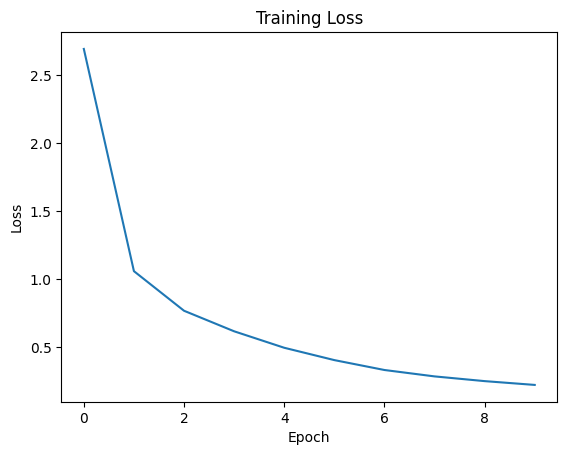

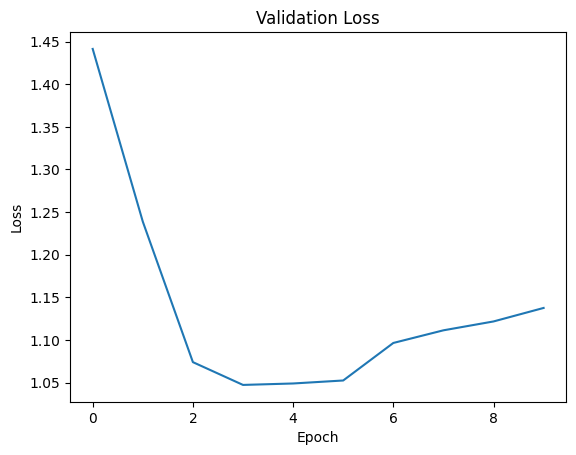

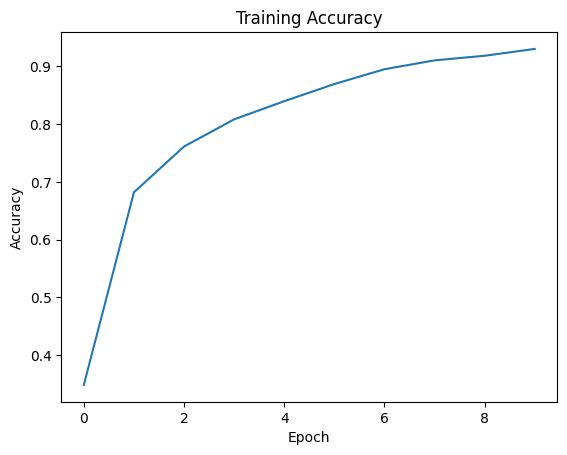

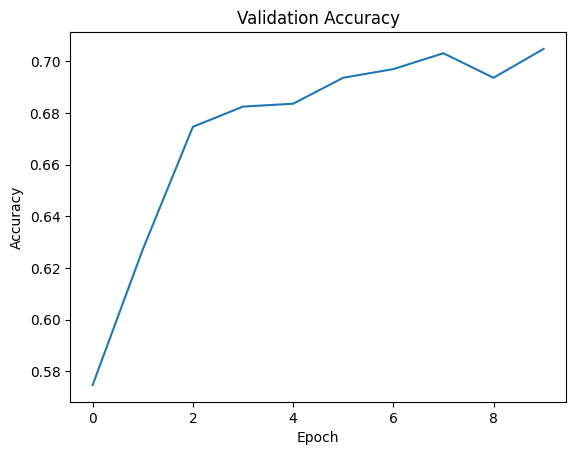

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Test

In [ ]:
breed_labels = sorted(os.listdir('/content/images/Images'))

In [ ]:
breed_labels

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [ ]:
from tkinter import *
from PIL import ImageTk, Image

In [ ]:
test_dir = '/content/dataset/test'  

# Get the list of test image file names
test_filenames = []

for dir in os.listdir(test_dir):
  sub_dir = os.path.join(test_dir, dir)
  for file in os.listdir(sub_dir):
    test_file_dir = os.path.join(sub_dir, file)
    test_filenames.append(test_file_dir)

num_correct = 0
num_total = 0

# Iter test image and count
for filename in test_filenames:
    image = Image.open(filename)
    image = image.resize((224, 224))  # Resize 
    image = np.array(image) / 255.0  # Normalize 
    image = np.expand_dims(image, axis=0)  

    # Perform inference on the test image
    predictions = model.predict(image)

    # Get the predicted dog breed
    predicted_breed_index = np.argmax(predictions)
    predicted_breed = breed_labels[predicted_breed_index]
    print('pred: ', predicted_breed)

    # Get the actual dog breed
    filedir = os.path.dirname(filename)
    actual_breed = filedir.split('/')[-1]
    print('act: ', actual_breed)

    # Count corretness
    if predicted_breed == actual_breed:
        num_correct += 1

    num_total += 1

# Calculate accuracy
accuracy = num_correct / num_total
print('Accuracy:', accuracy)


Streaming output truncated to the last 5000 lines.
act:  n02099601-golden_retriever
1/1 [==============================] - 0s 54ms/step
pred:  n02087394-Rhodesian_ridgeback
act:  n02099601-golden_retriever
1/1 [==============================] - 0s 55ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 46ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 55ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 52ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 47ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 46ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==============================] - 0s 50ms/step
pred:  n02105056-groenendael
act:  n02105056-groenendael
1/1 [==========================

In [ ]:
# TEST ONLY
# Check one test image
image_path = '/content/dataset/test/n02085620-Chihuahua/n02085620_10131.jpg' 
image = Image.open(image_path)
image = image.resize((224, 224))  # Resize 
image = np.array(image) / 255.0  # Normalize 
image = np.expand_dims(image, axis=0) 

predictions = model.predict(image)

predicted_breed_index = np.argmax(predictions)
predicted_breed = breed_labels[predicted_breed_index] 

print('Predicted Dog Breed:', predicted_breed)

1/1 [==============================] - 0s 45ms/step
Predicted Dog Breed: n02085620-Chihuahua


## Export

In [ ]:
!pip install tensorflowjs==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 13.0 MB/s eta 0:00:00
  Created wheel for h5py: filename=h5py-2.10.0-cp39-cp39-linux_x86_64.whl size=5731947 sha256=43f73db915ab7a3881646dc7958b110debd3b8bff6378a2a6bde366751df8340
  Stored in directory: /root/.cache/pip/wheels/91/57/54/aa5901c840e89c1e931141d848b27421f68ad98bd285cc4036
Successfully built h5py
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.8.0
    Uninstalling h5py-3.8.0:
      Successfully uninstalled h5py-3.8

In [ ]:
import tensorflowjs as tfjs

In [ ]:
# Export the model as TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')  # Save the model in TensorFlow.js format